In [24]:
from sklearn.metrics import auc
from matplotlib.patches import Rectangle
import numpy as np
from shapely.geometry import box
import supervision as sv

### IoU Calculation 

In [25]:
def iou(a, b):
    a = np.array(a)
    b = np.array(b)
    
    x1 = a[0] - a[2]/2
    y1 = a[1] - a[3]/2
    X1 = a[0] + a[2]/2
    Y1 = a[1] + a[3]/2
    
    x2 = b[0] - b[2]/2
    y2 = b[1] - b[3]/2
    X2 = b[0] + b[2]/2
    Y2 = b[1] + b[3]/2
    
    b1 = box(x1, y1, X1, Y1)
    b2 = box(x2, y2, X2, Y2)
    
    i = b1.intersection(b2).area
    u = b1.union(b2).area
    
    return i/u if u > 0 else 0

In [26]:
#overlapping
a = [.5, .5, .4, .4]
b = [.7, .7, .4, .4]

r1 = iou(a, b)
a1 = np.array([[a[0] - a[2]/2, a[1] - a[3]/2, a[0] + a[2]/2, a[1] + a[3]/2]])
b1 = np.array([[b[0] - b[2]/2, b[1] - b[3]/2, b[0] + b[2]/2, b[1] + b[3]/2]])
r2 = sv.detection.utils.box_iou_batch(a1, b1)[0][0]

print(f"{r1:.4f}\n{r2:.4f}\n{abs(r1-r2):.4f}")

0.1429
0.1429
0.0000


In [27]:
#non-overlapping
c = [.2, .2, .2, .2]
d = [.8, .8, .2, .2]

r1 = iou(c, d)
c1 = np.array([[c[0] - c[2]/2, c[1] - c[3]/2, c[0] + c[2]/2, c[1] + c[3]/2]])
d1 = np.array([[d[0] - d[2]/2, d[1] - d[3]/2, d[0] + d[2]/2, d[1] + d[3]/2]])
r2 =sv.detection.utils.box_iou_batch(c1, d1)[0][0]

print(f"{r1:.4f}\n{r2:.4f}\n{abs(r1-r2):.4f}")

0.0000
0.0000
0.0000


In [28]:
#fully-overlapping
e = [.5, .5, .3, .3]
f = [.5, .5, .3, .3]

r1 = iou(e, f)
e1 = np.array([[e[0] - e[2]/2, e[1] - e[3]/2, e[0] + e[2]/2, e[1] + e[3]/2]])
f1 = np.array([[f[0] - f[2]/2, f[1] - f[3]/2, f[0] + f[2]/2, f[1] + f[3]/2]])
r2 = sv.detection.utils.box_iou_batch(e1, f1)[0][0]

print(f"{r1:.4f}\n{r2:.4f}\n{abs(r1-r2):.4f}")

1.0000
1.0000
0.0000


In [29]:
def rand_boxes(num_boxes, img_size=100, box_size=20, n = 0.2):
    boxes = []
    pred_boxes = []
    conf_scores = []
    for _ in range(num_boxes):
        x = np.random.uniform(box_size/2, img_size - box_size/2)
        y = np.random.uniform(box_size/2, img_size - box_size/2)
        boxes.append([x, y, box_size, box_size])
    for box in boxes:
        n_x = np.random.normal(0, n * box[2])
        n_y = np.random.normal(0, n * box[3])
        
        noisy_box = [
            box[0] + n_x,
            box[1] + n_y,
            box[2],
            box[3]
        ]
        
        total = (abs(n_x) + abs(n_y)) / 2
        score = np.clip(1.0 - total / box[2], 0.3, 0.95)
        pred_boxes.append(noisy_box)
        conf_scores.append(score)
    
    return np.array(boxes), np.array(pred_boxes), np.array(conf_scores) 

### AP Calculation

In [30]:
def AP(prec, rec, method='auc'):
    if method == 'voc11':
        ap = 0
        for t in np.arange(0, 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 11
        return ap
    elif method == 'coco101':
        ap = 0
        for t in np.arange(0, 1.01, 0.01):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 101
        return ap
    else:
        idx = np.argsort(rec)
        rec = rec[idx]
        prec = prec[idx]
        rec = np.concatenate(([0.], rec, [1.]))
        prec = np.concatenate(([0.], prec, [0.]))
        for i in range(prec.size - 1, 0, -1):
            prec[i - 1] = np.maximum(prec[i - 1], prec[i])
        unique_rec = np.where(rec[1:] != rec[:-1])[0]
        rec = rec[np.r_[unique_rec, rec.size-1]]
        prec = prec[np.r_[unique_rec, prec.size-1]]
            
        return auc(rec, prec)
 
def eval(true_boxes, pred_boxes, scores, iou_thresh=0.5):
    num_true = len(true_boxes)
    num_pred = len(pred_boxes)
    
    if num_true == 0 or num_pred == 0:
        return np.array([0.0]), np.array([0.0])

    idx = np.argsort(scores)[::-1]
    pred_boxes = pred_boxes[idx]
    scores = scores[idx]
    
    true_matched = np.zeros(num_true, dtype=bool)
    true_pos = np.zeros(num_pred)
    false_pos = np.zeros(num_pred)
    
    for i in range(num_pred):
        best_iou = 0
        best_match = -1
        
        for j in range(num_true):
            if true_matched[j]:
                continue
            curr_iou = iou(pred_boxes[i], true_boxes[j])
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_match = j
        if best_iou >= iou_thresh:
            true_pos[i] = 1
            true_matched[best_match] = True
        else:
            false_pos[i] = 1
    
    fp_sum = np.cumsum(false_pos)
    tp_sum = np.cumsum(true_pos)
    recalls = tp_sum / (num_true + 1e-10)
    precisions = tp_sum / (tp_sum + fp_sum + 1e-10)
    
    if len(precisions) < 2:
        precisions = np.array([1.0, 0.0])
        recalls = np.array([0.0, 1.0])
    
    return precisions, recalls

In [31]:
def plot(true_boxes, pred_boxes, scores, img_num, ap_vals, ax):
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    for box in true_boxes:
        x, y, w, h = box
        rect = Rectangle((x - w/2, y - h/2), w, h, linewidth=2,
                        edgecolor='g', facecolor='none', alpha=0.7, label='Ground Truth')
        ax.add_patch(rect)
    for box, score in zip(pred_boxes, scores):
        x, y, w, h = box
        rect = Rectangle((x - w/2, y - h/2), w, h, linewidth=2,
                        edgecolor='r', facecolor='none', alpha=0.7, label='Prediction')
        ax.add_patch(rect)
        ax.text(x, y, f'{score:.2f}', color='r', ha='center', va='center')
    
    title = f'Image {img_num + 1}\n'
    title += f'AP50: {ap_vals[2]:.3f}'
    
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.grid(True)

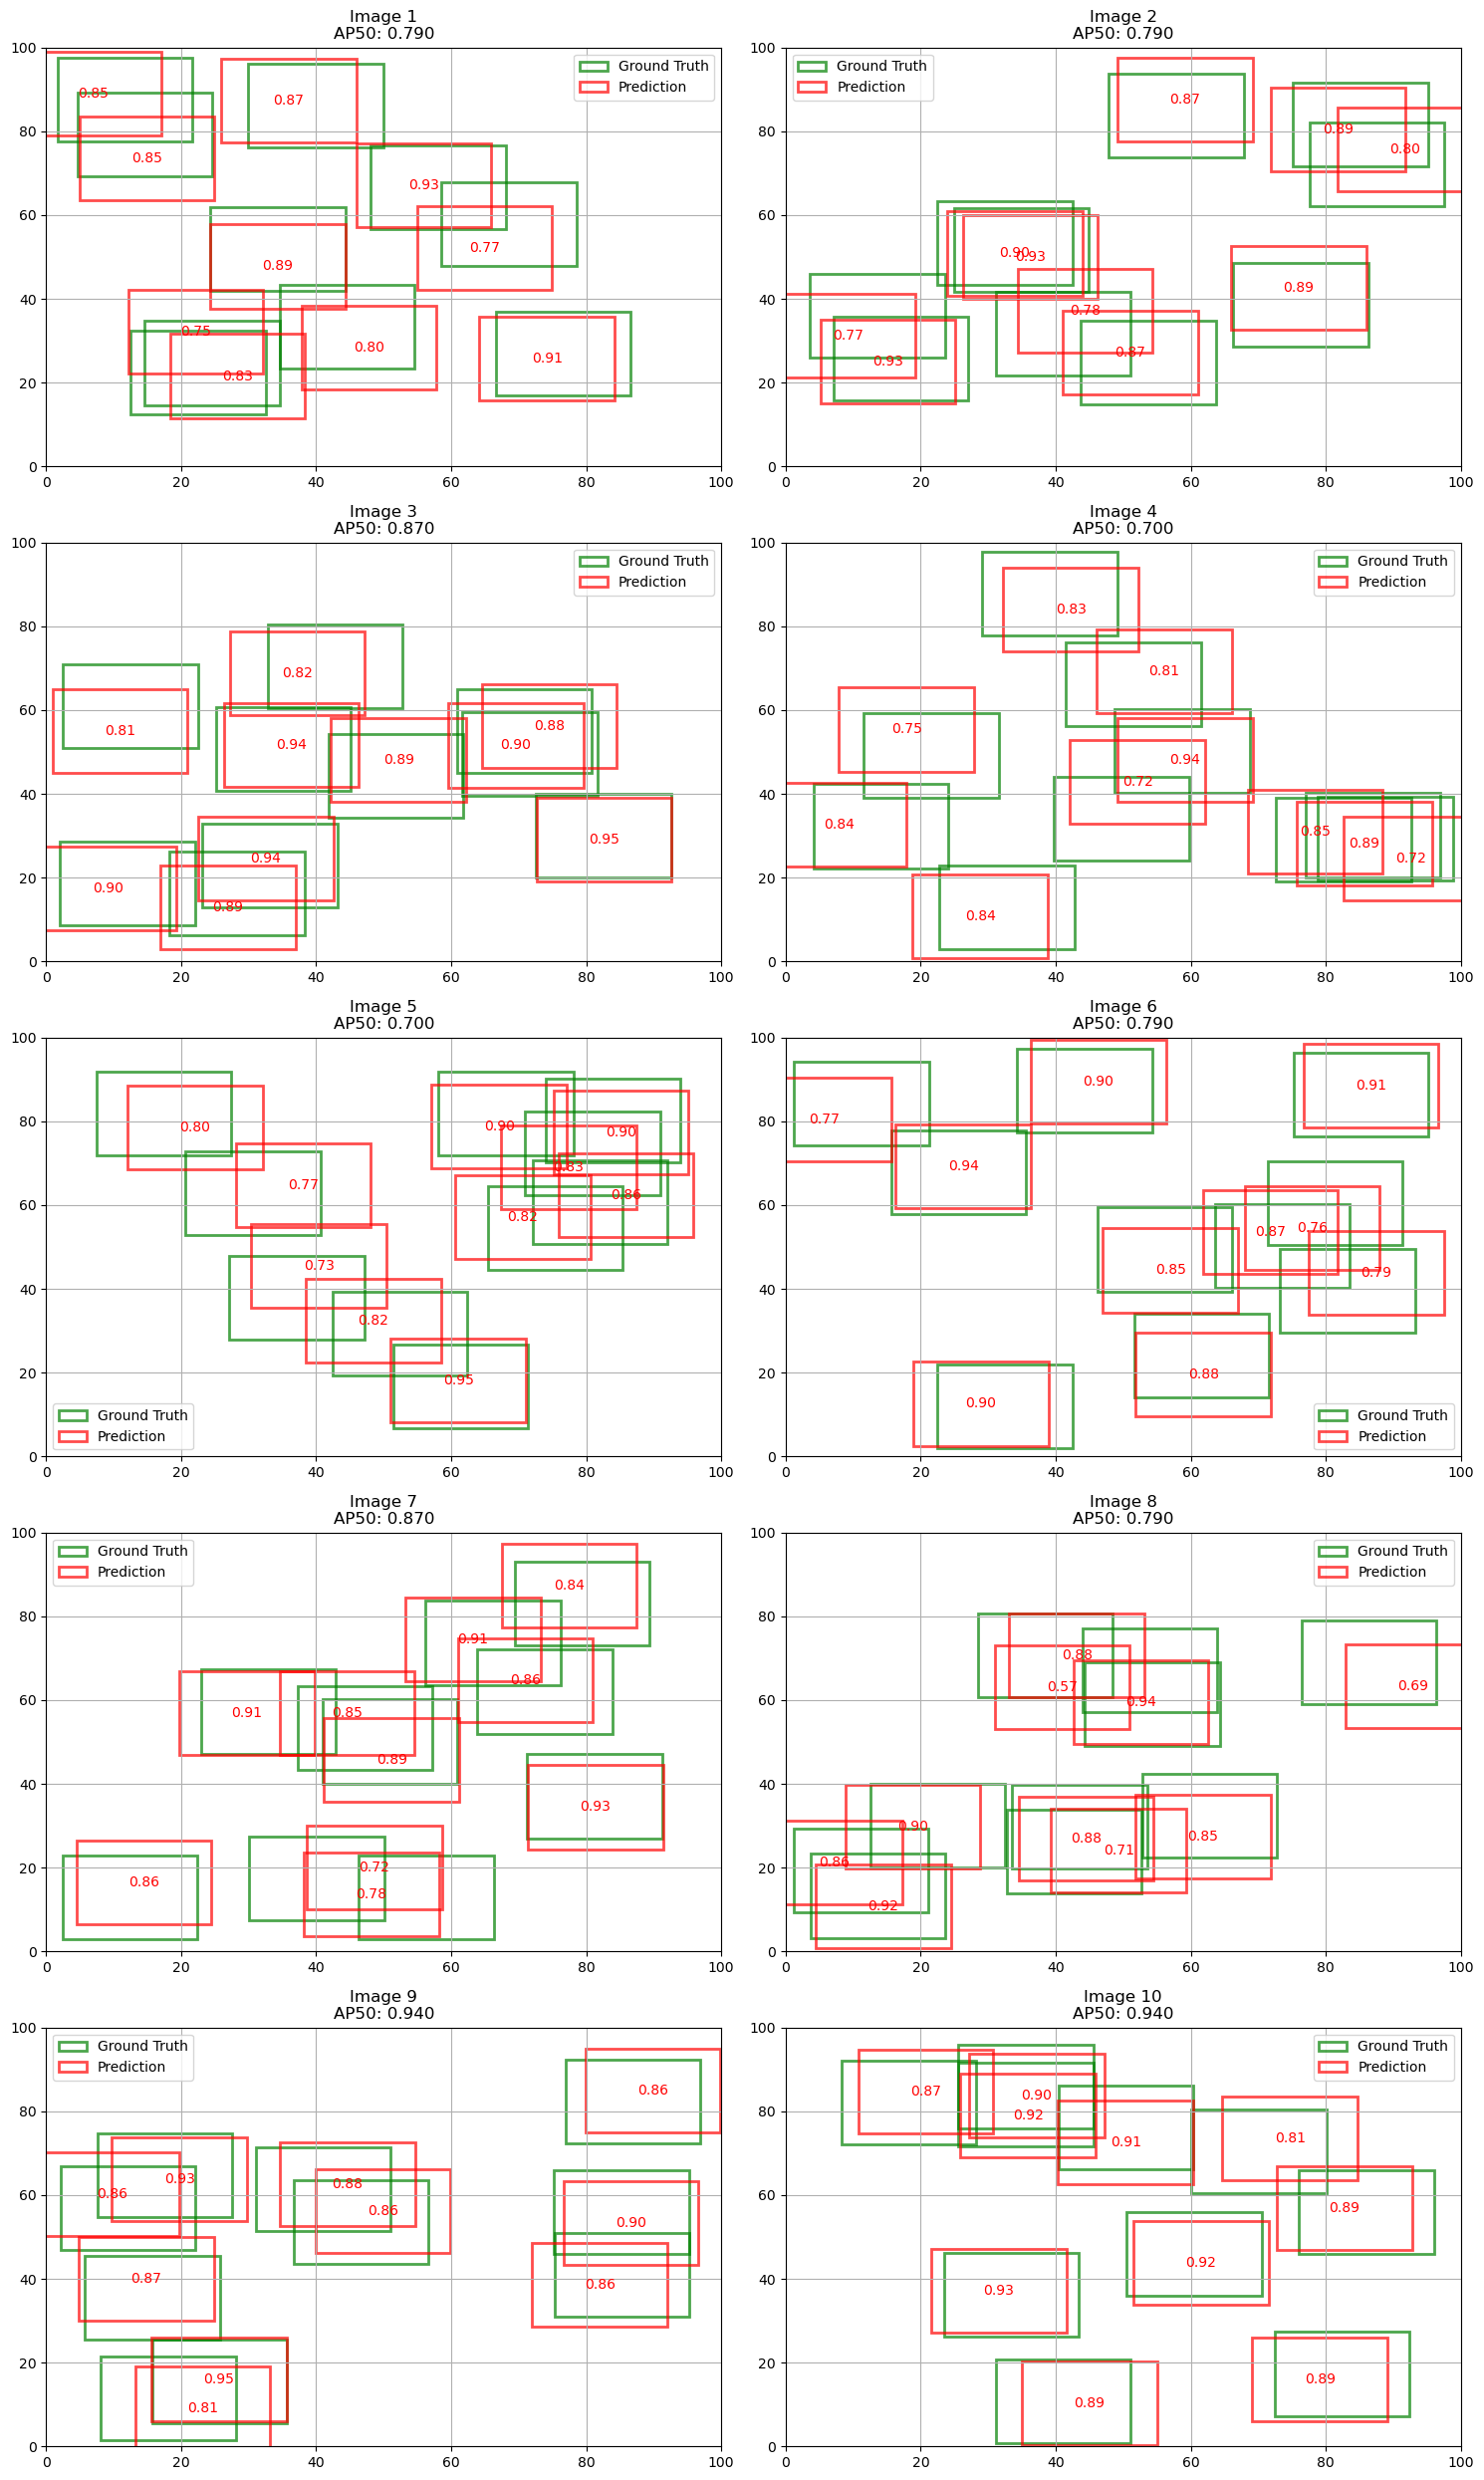

In [32]:
np.random.seed(42)
num_images = 10
results = []
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.ravel()
for i in range(num_images):
    true_boxes, pred_boxes, scores = rand_boxes(10)
    prec, rec = eval(true_boxes, pred_boxes, scores)
    ap_11 = AP(prec, rec, 'voc11')
    ap_101 = AP(prec, rec, 'coco101')
    ap_auc = AP(prec, rec, 'auc')
    
    results.append([ap_11, ap_101, ap_auc])
    plot(true_boxes, pred_boxes, scores, i, [ap_11, ap_101, ap_auc], axes[i])

plt.tight_layout()
plt.show()

In [33]:
results = np.array(results)
avg_ap = np.mean(results, axis=0)

print("\nAverage AP50 across images:")
print(f"11-point: {avg_ap[0]:.3f}")
print(f"101-point: {avg_ap[1]:.3f}")
print(f"AUC: {avg_ap[2]:.3f}")


Average AP50 across images:
11-point: 0.673
101-point: 0.733
AUC: 0.818
